## ETL

In [6]:
import numpy as np
import pandas as pd
import psycopg2

# Get data from DB

from config import config

params = config()
conn = psycopg2.connect(**params)
cur = conn.cursor()
cur.execute("select * from dataentry_cifnepal as CIF inner join dataentry_personboxnepal as PB on CIF.id = PB.cif_id;")
colnames = [desc[0] for desc in cur.description]
rows = cur.fetchall()
df = pd.DataFrame(rows, columns = colnames)
cur.close()

In [2]:
# Data Processing / Create Unique Suspect ID number
dfcols = list(df.columns)
dfcols[16] = 'pv_occupation'
df.columns = dfcols

df['pb_number']=df['pb_number'].fillna(0).astype(int)
df['suspect_id'] = df['cif_number'].str.replace('.','')
df['suspect_id'] = df['suspect_id'].str[:-1] + ".PB" + df['pb_number'].map(str)
df = df.drop_duplicates(subset='suspect_id')

#Remove columns that won't be used
dropcols = [
        'id','date_time_entered_into_system','status','location','date_time_last_updated','staff_name',
        'informant_number','case_notes', 'pv_signed_form', 'consent_for_fundraising', 'guardian_name', 
        'guardian_phone', 'social_media', 'permission_contact_pv', 'permission_contact_whats_app', 
        'permission_contact_facebook', 'permission_contact_phone', 'legal_action_taken_filed_against', 
        'officer_name', 'cif_id', 'person_id', 'flag_count', 'main_pv_id', 'expected_earning',
        'expected_earning_currency','travel_expenses_paid_to_broker_amount','broker_relation',
        'travel_expenses_broker_repaid_amount','form_entered_by_id', 'source_of_intelligence', 
        'date_time_last_updated','interview_date','incident_date','how_recruited_broker_other',
        'legal_action_taken','legal_action_taken_case_type','appearance','date_visit_police_station',
        'victim_statement_certified_date','purpose_for_leaving_other','relation_to_pv',
        'exploitation_forced_prostitution_lb','exploitation_sexual_abuse_lb','associated_lb',
        'exploitation_debt_bondage_lb','exploitation_forced_labor_lb','exploitation_physical_abuse_lb',
        'exploitation_organ_removal_lb','exploitation_other_value','exploitation_other_lb']

df1 = df.drop(columns = dropcols)

#Add Arrest data
Arrests = pd.read_csv("Arrests.csv")
df1 = pd.merge(df1, Arrests, how='outer',on='suspect_id', sort=True,
         suffixes=('x', 'y'))
df1.Arrest=df1.Arrest.fillna('0').astype(int)
df1 = df1.dropna(axis=0, subset=['cif_number'])

## EDA

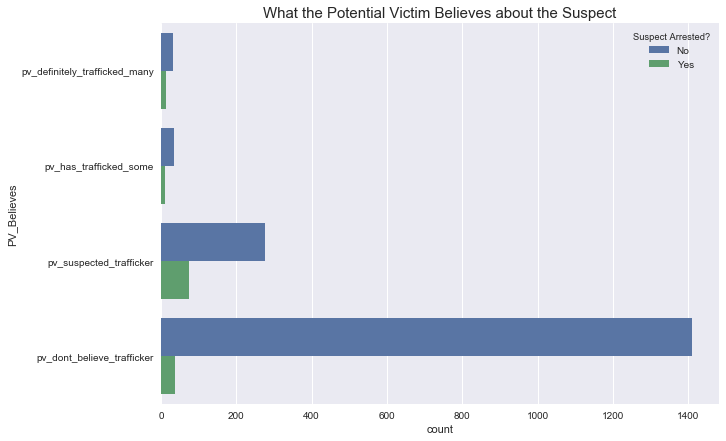

In [14]:
#Look at total arrests by "potential victim believes" response
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

pv_believes = df1[['pv_definitely_trafficked_many', 'pv_has_trafficked_some', 'pv_suspected_trafficker', 
           'pv_dont_believe_trafficker', 'Arrest']]
pv_believes = pd.melt(pv_believes, id_vars = ['Arrest'], value_vars = ['pv_definitely_trafficked_many', 'pv_has_trafficked_some', 
                                                       'pv_suspected_trafficker', 'pv_dont_believe_trafficker'],
                   var_name='PV_Believes', value_name='PV_BVal')
pv_believes = pv_believes[pv_believes.PV_BVal]

pdim=(10,7)
fig, ax = plt.subplots(figsize=pdim)
g = sns.countplot(ax=ax,y="PV_Believes", hue="Arrest",
                data=pv_believes);
g.set_title("What the Potential Victim Believes about the Suspect",fontsize=15)
leg = g.get_legend()
leg.set_title("Suspect Arrested?")
labs = leg.texts
labs[0].set_text("No")
labs[1].set_text("Yes")

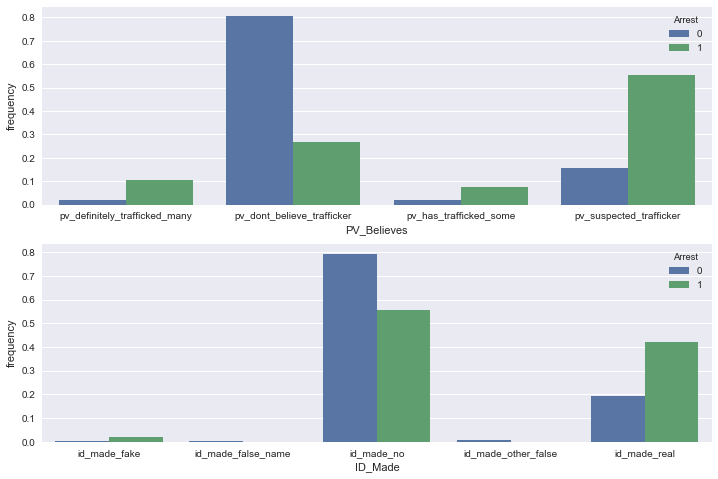

In [15]:
#Look at percentage of arrests by "potential victim believes" and "ID Made" responses

id_made = pd.melt(df1, id_vars =['Arrest'], value_vars =['id_made_no','id_made_real','id_made_fake','id_made_false_name',
                                                     'id_made_other_false'],
              var_name='ID_Made', value_name='ID_Val')
id_made = id_made[id_made.ID_Val]
pv_believes = pv_believes.set_index(['Arrest', pv_believes.groupby('Arrest').cumcount()])
id_made = id_made.set_index(['Arrest', id_made.groupby('Arrest').cumcount()])
id_and_pvb = (pd.concat([pv_believes, id_made],axis=1)
         .sort_index(level=1)
         .reset_index(level=1, drop=True)
         .reset_index())

fig, axes = plt.subplots(2,1, figsize=(12,8))

id_and_pvb['frequency'] = 0
for col, ax in zip(['PV_Believes','ID_Made'], axes.flatten()):
    counts = id_and_pvb.groupby([col,'Arrest']).count()
    freq_per_group = counts.div(counts.groupby('Arrest').transform('sum')).reset_index()
    sns.barplot(x=col,y='frequency', hue='Arrest',data=freq_per_group,ax=ax)

## Feature Engineering and Preprocessing Data

In [17]:
df1['planned_destination'] = df1['planned_destination'].str.replace(r'[^\w\s]+', '')
df1['destination_gulf'] = np.where(df1['planned_destination'].str.contains(
    'Gulf|Kuwait|Dubai|UAE|Oman|Saudi|Iraq|Qatar|Bahrain'),True,False)
df1['destination_unknown'] = np.where(df1['planned_destination'].str.contains('know'),True,False)

dest = ['Nepal','India','Delhi','Gorakhpur','Bihar','Mumbai','Sunauli','Banaras','Kolkata']
for d in dest:
    df1['destination_' + str(d)] = np.where(df1['planned_destination'].str.contains(d),True,False)

df1.pb_number = df1.pb_number.fillna(0)
df1.pb_number = df1.pb_number.astype(int)

PB_fields = ['id_source_pb','recruited_agency_pb','recruited_broker_pb','how_recruited_broker_online_pb',
             'exploitation_sexual_abuse_pb','how_recruited_broker_approached_pb', 'known_broker_pb',
             'expected_earning_pb','exploitation_forced_prostitution_pb','exploitation_forced_labor_pb',
             'exploitation_organ_removal_pb','exploitation_other_pb','married_broker_pb',
             'travel_expenses_paid_by_broker_pb','travel_expenses_paid_by_broker_repaid_pb',
             'travel_expenses_paid_to_broker_pb','exploitation_physical_abuse_pb','exploitation_debt_bondage_pb']
#The variables in 'PB_fields' contain number(s) for the corresponding Person Box (PB) if the variable is relevant
 
def check_match(x):
    """Checks to see whether the first value is equal to or within the second value."""
    return str(x[0]) in list(str(x[1]))

for PBf in PB_fields:
    df1[PBf + "2"] = df1[['pb_number', PBf]].apply(check_match, axis=1)

df1 = df1.drop(columns=['planned_destination','pb_number'])
df1 = df1.drop(columns = PB_fields)


#Organizing/preprocessing data

numerical_features = ['number_of_victims','number_of_traffickers','known_broker_years', 'known_broker_months',
                      'married_broker_years', 'married_broker_months','reported_blue_flags','total_blue_flags',
                      'suspected_trafficker_count']

categorical_features = ['education','guardian_relationship','station_id','role','pv_occupation','occupation']

boolean_features = list(
    set(list(df1.columns)) - set(numerical_features) - set(categorical_features)
)

df1[boolean_features] = df1[boolean_features].astype(bool)

df1[numerical_features] = df1[numerical_features].fillna(0).astype(float)

for f in categorical_features:
    df1[f] = df1[f].astype("category")

for cf in categorical_features:
    for elem in df1[cf].unique():
        df1[str(cf) + "_" + str(elem)] = df1[str(cf)] == elem
df1 = df1.drop(columns = categorical_features)

# Train/Test Split
from sklearn.model_selection import train_test_split
X = (df1.drop(columns=['Arrest','Arrest_Date','cif_number','suspect_id']))
y = df1.Arrest

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.125)

## Building and Using Pipelines

In [68]:
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

class TypeSelector(BaseEstimator, TransformerMixin):
    """This is a class for """
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

transformer = Pipeline([
    ('features', FeatureUnion(n_jobs=1, transformer_list=[
        ('boolean', Pipeline([
            ('selector', TypeSelector('bool')),
        ])),
        
        ('numericals', Pipeline([
            ('selector', TypeSelector(np.number)),
            ('scaler', StandardScaler()),
        ]))
    ])),
])

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

cls_pipeline = Pipeline([
    ('transformer', transformer),
    ('clf', SGDClassifier())
])

cls_pipeline.fit(X_train, y_train)
y_sgd = cls_pipeline.decision_function(X_validation)

cls_pipeline.set_params(clf=RandomForestClassifier())
cls_pipeline.fit(X_train, y_train)
y_rf = cls_pipeline.predict_proba(X_validation)

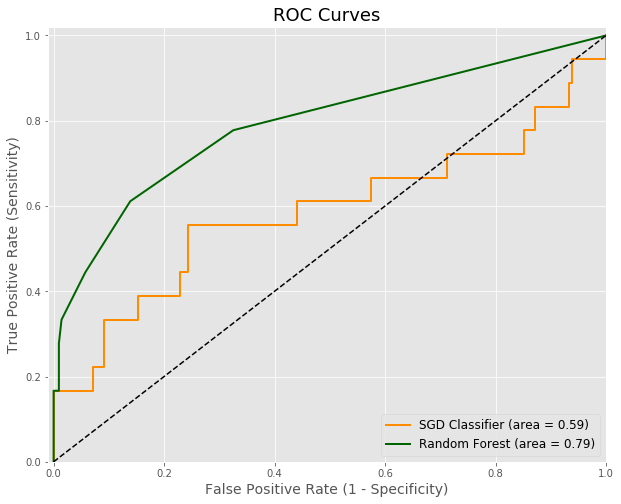

In [69]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_validation, y_sgd)
roc_auc = auc(fpr, tpr)

rf_fpr, rf_tpr, thresholds = roc_curve(y_validation, y_rf[:, 1])
rf_roc_auc = auc(rf_fpr, rf_tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='SGD Classifier (area = %0.2f)' % roc_auc)
plt.plot(rf_fpr, rf_tpr, color='darkgreen',
         lw=2, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate (1 - Specificity)', size=14)
plt.ylabel('True Positive Rate (Sensitivity)', size=14)
plt.title('ROC Curves', fontsize=18)
plt.legend(loc="lower right", fontsize=12)
plt.show()

## Grid Search

In [34]:
from sklearn.model_selection import GridSearchCV
from time import time

search_space = [{'clf': [SGDClassifier()],
                 'clf__alpha': (0.00001, 0.000001),
                 'clf__penalty': ['l1','l2', 'elasticnet'],
                 'clf__learning_rate': ['optimal','adaptive'],
                 'clf__eta0': (0.00001, 0.000001),
                 'clf__class_weight': ['balanced',None]},
                {'clf': [RandomForestClassifier()],
                 'clf__bootstrap': [False, True],
                 'clf__n_estimators': [10,100],
                 'clf__max_depth': [5, 10, 20, 30, 40, 50, None],
                 'clf__max_features': [0.5, 0.6, 0.7, 0.8, 1],
                 'clf__class_weight': ["balanced","balanced_subsample",None]}]
        
                 #'clf__min_samples_leaf': [10, 12, 15, 20, 50],


if __name__ == "__main__":
    grid_search = GridSearchCV(cls_pipeline, search_space, cv=5, n_jobs=-1,verbose=1)

    print("Performing grid search...")
    print("parameters:")
    print(search_space)
    t0 = time()
    best_model=grid_search.fit(X_train,y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    best_parameters = best_model.best_estimator_.get_params()['clf']
    
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    print(best_parameters)

Performing grid search...
parameters:
[{'clf': [SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)], 'clf__alpha': (1e-05, 1e-06), 'clf__penalty': ['l1', 'l2', 'elasticnet'], 'clf__learning_rate': ['optimal', 'adaptive'], 'clf__eta0': (1e-05, 1e-06), 'clf__class_weight': ['balanced', None]}, {'clf': [RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
         

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 2340 out of 2340 | elapsed: 23.0min finished


done in 1379.876s

Best score: 0.942
Best parameters set:
RandomForestClassifier(bootstrap=False, class_weight='balanced',
            criterion='gini', max_depth=30, max_features=1,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


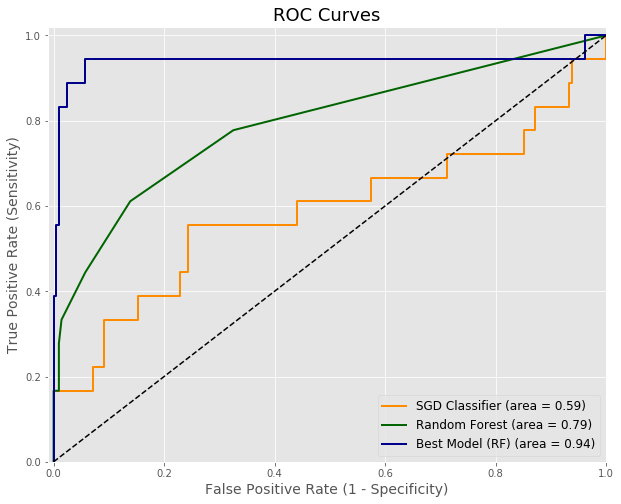

In [71]:
y_rf_best = best_model.predict_proba(X_validation)

fpr, tpr, thresholds = roc_curve(y_validation, y_sgd)
roc_auc = auc(fpr, tpr)

rf_fpr, rf_tpr, thresholds = roc_curve(y_validation, y_rf[:, 1])
rf_roc_auc = auc(rf_fpr, rf_tpr)

rf_best_fpr, rf_best_tpr, thresholds = roc_curve(y_validation, y_rf_best[:, 1])
rf_best_roc_auc = auc(rf_best_fpr, rf_best_tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='SGD Classifier (area = %0.2f)' % roc_auc)
plt.plot(rf_fpr, rf_tpr, color='darkgreen',
         lw=2, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot(rf_best_fpr, rf_best_tpr, color='darkblue',
         lw=2, label='Best Model (RF) (area = %0.2f)' % rf_best_roc_auc)
#plt.plot(cv_rf_fpr, cv_rf_tpr, color='blue',
#         lw=2, label='Random Forest CV (area = %0.2f)' % cv_rf_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate (1 - Specificity)', size=14)
plt.ylabel('True Positive Rate (Sensitivity)', size=14)
plt.title('ROC Curves', fontsize=18)
plt.legend(loc="lower right", fontsize=12)
plt.show()

In [72]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

threshold = 0.6

y_pred = (y_rf_best[:, 1] >= threshold).astype('int')
y_true = y_validation
target_names = ['No Arrest','Arrest']

print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   No Arrest       0.98      0.99      0.99       209
      Arrest       0.88      0.78      0.82        18

   micro avg       0.97      0.97      0.97       227
   macro avg       0.93      0.88      0.90       227
weighted avg       0.97      0.97      0.97       227

